In [ ]:
# Импорт библиотек
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.applications import VGG16
from keras.models import load_model
from google.colab import files
from keras.applications.vgg16 import preprocess_input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Сохраним путь к изображениям
PATH_TO_IMAGES = '/content/drive/MyDrive/US/Fetal/images'

In [ ]:
# Загрузим датафрейм из csv-файла
df = pd.read_csv('/content/drive/MyDrive/US/Fetal/image_label.csv')

In [ ]:
# Посмотрим на датафрейм
print(df.head(10))
print('-------------------------------')
print(f'Количество строк: {df.shape[0]}, количество столбцов: {df.shape[1]}')

                   Image_name        Plane
0  Patient01018_Plane3_2_of_3  Fetal brain
1  Patient00770_Plane3_2_of_3  Fetal brain
2  Patient00853_Plane3_1_of_3  Fetal brain
3  Patient01230_Plane3_5_of_5  Fetal brain
4  Patient01494_Plane3_3_of_4  Fetal brain
5  Patient01699_Plane3_1_of_2  Fetal brain
6  Patient01458_Plane3_1_of_2  Fetal brain
7  Patient01298_Plane3_8_of_9  Fetal brain
8  Patient01507_Plane3_2_of_2  Fetal brain
9  Patient01718_Plane3_1_of_4  Fetal brain
-------------------------------
Количество строк: 1646, количество столбцов: 2


In [ ]:
# Посмотрим на количество уникальных лейблов и количество изображений в каждом из них
df['Plane'].value_counts()

Fetal brain      556
Fetal thorax     451
Fetal abdomen    339
Fetal femur      300
Name: Plane, dtype: int64

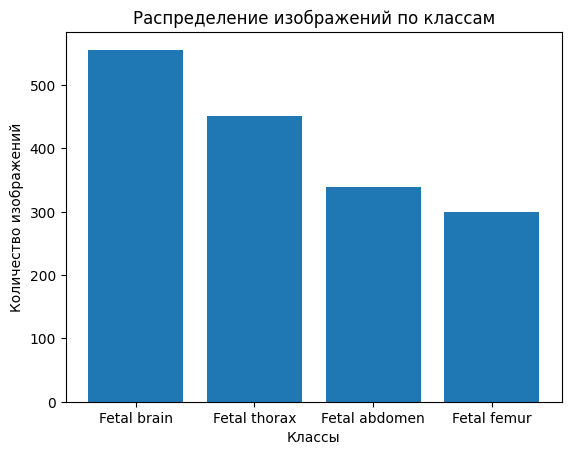

In [ ]:
# Построим график распределения изображений по классам
classes = ['Fetal brain', 'Fetal thorax', 'Fetal abdomen', 'Fetal femur']
values = [value for value in df['Plane'].value_counts()[0:]]
plt.bar(classes, values)
plt.xlabel('Классы')
plt.ylabel('Количество изображений')
plt.title('Распределение изображений по классам')
plt.show()

In [ ]:
# Добавим к названиям изображений наименование формата, чтобы генератор изображений смог соотнести изображения с их названиями
df['Image_name'] = df['Image_name'].apply(lambda x: f'{x}.png')
df

,Image_name,Plane
0,Patient01018_Plane3_2_of_3.png,Fetal brain
1,Patient00770_Plane3_2_of_3.png,Fetal brain
2,Patient00853_Plane3_1_of_3.png,Fetal brain
3,Patient01230_Plane3_5_of_5.png,Fetal brain
4,Patient01494_Plane3_3_of_4.png,Fetal brain
...,...,...
1641,Patient00647_Plane2_1_of_1.png,Fetal abdomen
1642,Patient00829_Plane2_1_of_1.png,Fetal abdomen
1643,Patient01533_Plane2_1_of_1.png,Fetal abdomen
1644,Patient01589_Plane2_1_of_1.png,Fetal abdomen


In [ ]:
# Создадим ImageDataGenerator для форматирования изображений
datagen = ImageDataGenerator(rescale=1/255., rotation_range=10, horizontal_flip=True, validation_split=0.2)

In [ ]:
# Преобразуем изображения для обучающей выборки
train_generator = datagen.flow_from_dataframe(dataframe=df,
                                             directory=PATH_TO_IMAGES,
                                             x_col='Image_name',
                                             y_col='Plane',
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             batch_size=16,
                                             shuffle=True,
                                             subset='training',
                                             stratify=df['Plane'],
                                             preprocessing_function=preprocess_input,
                                             seed=12345)


Found 1317 validated image filenames belonging to 4 classes.


In [ ]:
# Преобразуем изображения для валидационной выборки
validation_generator = datagen.flow_from_dataframe(dataframe=df,
                                                  directory=PATH_TO_IMAGES,
                                                  x_col='Image_name',
                                                  y_col='Plane',
                                                  target_size=(224, 224),
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  subset='validation',
                                                  stratify=df['Plane'],
                                                  preprocessing_function=preprocess_input,
                                                  seed=12345)

Found 329 validated image filenames belonging to 4 classes.


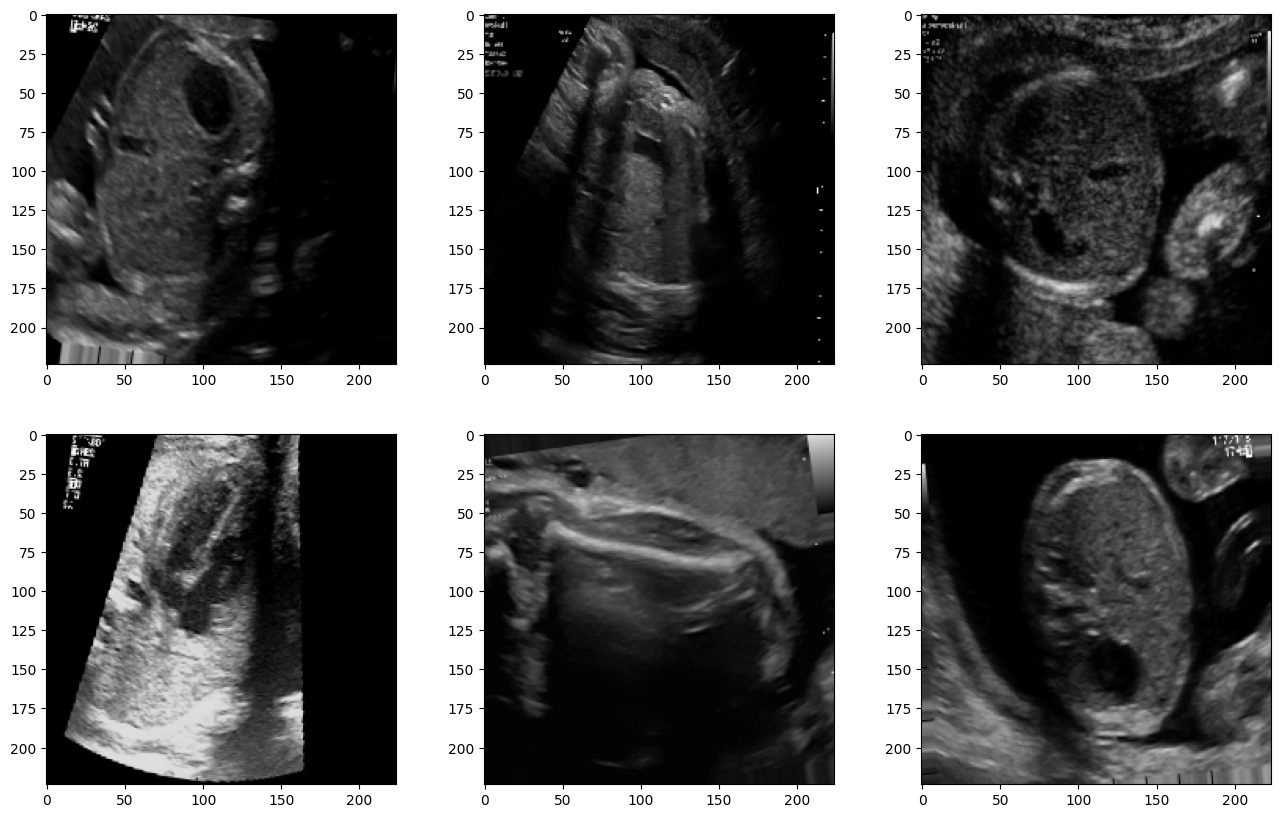

In [ ]:
# Посмотрим на случайные 6 изображений
features, target = next(train_generator)
pic_box = plt.figure(figsize=(16, 10))
for i in range(6):
    pic_box.add_subplot(2, 3, i+1)
    plt.imshow(features[i])

In [ ]:
# Воспользуемся предобученной моделью VGG16
from keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224) + (3,))

for layer in base_model.layers:
    layer.trainable = False
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/models/best_model_fetal.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)


In [ ]:
# Обучим модель
train_steps = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size
history = model.fit(train_generator, steps_per_epoch=train_steps, epochs=100,
                    validation_data=validation_generator, validation_steps=validation_steps,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/100
82/82 [==============================] - ETA: 0s - loss: 1.6901 - accuracy: 0.7110

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


82/82 [==============================] - 530s 6s/step - loss: 1.6901 - accuracy: 0.7110 - val_loss: 0.4052 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - 39s 478ms/step - loss: 0.4282 - accuracy: 0.8663 - val_loss: 0.2715 - val_accuracy: 0.9281 - lr: 0.0010
Epoch 3/100
82/82 [==============================] - 41s 489ms/step - loss: 0.3937 - accuracy: 0.8762 - val_loss: 0.3196 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 4/100
82/82 [==============================] - 38s 459ms/step - loss: 0.2557 - accuracy: 0.9268 - val_loss: 0.3700 - val_accuracy: 0.8781 - lr: 0.0010
Epoch 5/100
82/82 [==============================] - 38s 462ms/step - loss: 0.3354 - accuracy: 0.8809 - val_loss: 0.2964 - val_accuracy: 0.9094 - lr: 0.0010
Epoch 6/100
82/82 [==============================] - 39s 479ms/step - loss: 0.2041 - accuracy: 0.9339 - val_loss: 0.1340 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 7/100
82/82 [==============================] - 41s 503ms/step - lo

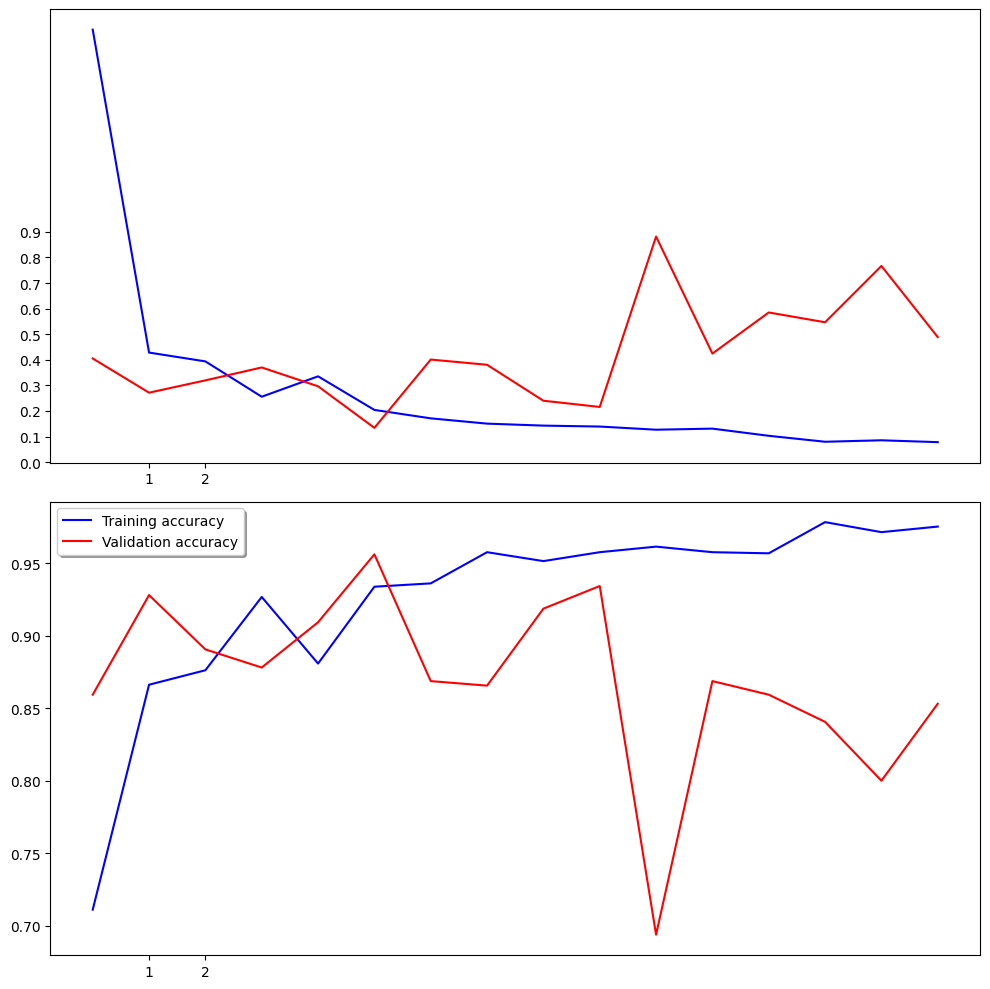

In [ ]:
# Построим графики динамики обучения модели в зависимости от эпох
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 3, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))


ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 3, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
# Напишем функцию для классификации изображения
def classify_image(model_path):
    model = load_model(model_path)
    uploaded = files.upload()
    organs = {'Fetal abdomen': 0,
              'Fetal brain': 1,
              'Fetal femur': 2,
              'Fetal thorax': 3}

    # Получение пути к загруженному файлу изображения
    image_path = list(uploaded.keys())[0]

    # Открытие изображения с помощью Pillow
    image = Image.open(image_path)

    # Вывод изображения на экран
    display(image)

    # Преобразование изображения в массив numpy
    image_array = np.array(image.resize((224, 224)))

    # Преобразование черно-белого изображения в формат RGB
    image_array = np.stack((image_array, image_array, image_array), axis=-1)

    # Нормализация массива изображения
    normalized_image_array = (image_array.astype(np.float32) / 255.0)

    # Добавление дополнительного измерения для пакета (batch dimension)
    batched_image_array = np.expand_dims(normalized_image_array, axis=0)

    # Классификация изображения с помощью модели
    predictions = model.predict(batched_image_array)

    # Вывод результатов классификации
    print("Результаты классификации:")
    for i, prediction in enumerate(predictions[0]):
        for k, v in organs.items():
            if i == v:
                print(f"Класс {k}: {int(prediction * 100)}%")

Saving Patient01650_Plane5_2_of_2.png to Patient01650_Plane5_2_of_2 (1).png


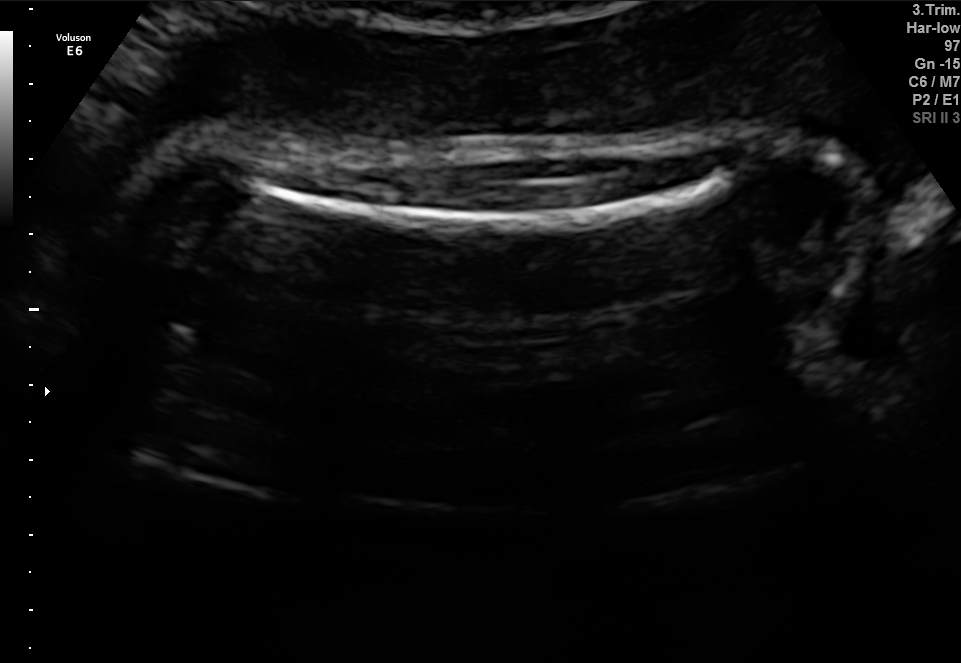

1/1 [==============================] - 1s 590ms/step
Результаты классификации:
Класс Fetal abdomen: 0%
Класс Fetal brain: 49%
Класс Fetal femur: 50%
Класс Fetal thorax: 0%


In [ ]:
classify_image('/content/drive/MyDrive/models/best_model_fetal.h5')